Mô hình: https://huggingface.co/spaces/kRnos22/image-caption-vi

In [1]:
!pip install -q pycocoevalcap

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install underthesea -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import fasttext

# Đường dẫn đến file fastText .bin đã add vào Kaggle notebook
embedding_path = "/kaggle/input/fasttext-vietnamese-word-vectors-full/cc.vi.300.bin"

# Load mô hình fastText
ft_model = fasttext.load_model(embedding_path)

# Kiểm tra thử
print(ft_model.get_word_vector("con"))  # từ "con" sẽ có vector 300 chiều


[-0.02213036 -0.04521639  0.1320183   0.00356279 -0.0414703  -0.02049387
  0.09272263  0.03314298  0.0261815  -0.02945328 -0.07337602 -0.139512
 -0.0652243  -0.00661636 -0.03837166  0.01989546  0.00088946  0.04582398
  0.02093197  0.04052743  0.10508441 -0.06163242  0.0716203   0.1669673
 -0.01353122  0.02087497 -0.03348445 -0.06689046 -0.0231114  -0.09641153
 -0.07905272 -0.00394306 -0.0160636  -0.06932102  0.00870908  0.07382067
  0.13883032 -0.05581042  0.06936662  0.0145606   0.06650957  0.04635757
  0.04485775 -0.04571567 -0.07795262 -0.0374807   0.08386357  0.00342294
  0.02325775 -0.09126826 -0.07017826 -0.06191577 -0.01909595  0.03896176
  0.02004015 -0.22821103 -0.09910659  0.00619015 -0.09202853  0.00892451
  0.08143297 -0.08401429  0.07374427 -0.13524905 -0.10780606 -0.00122827
 -0.03218555  0.02918637  0.13059656  0.04550584  0.01838978 -0.02239414
 -0.09731749 -0.06439064 -0.09219381  0.25053972 -0.08768644 -0.05859605
  0.01233335 -0.01670829 -0.21828297  0.12281475 -0.14

In [4]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from PIL import Image
import string
import re
import warnings
from underthesea import word_tokenize
warnings.filterwarnings("ignore", category=UserWarning)



class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold

    @staticmethod
    def tokenize(text):
        return word_tokenize(text.lower(), format="text").split()

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text] 

    def __len__(self):
        return len(self.itos)


def preprocess_caption(caption):
    caption = caption.lower().strip()
    caption = re.sub(r"\s+", " ", caption)
    return caption


class FlickrDataset(Dataset):
    def __init__(self, root_dir, caption_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform

        self.imgs = self.df["image"]
        self.captions = self.df["caption"].apply(preprocess_caption)

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())

        # Build embedding matrix từ fastText
        embedding_dim = 300
        vocab_size = len(self.vocab)
        embedding_matrix = np.zeros((vocab_size, embedding_dim))
        for idx, word in self.vocab.itos.items():
            embedding_matrix[idx] = ft_model.get_word_vector(word)

        self.embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        caption_vec = [self.vocab.stoi["<SOS>"]] + self.vocab.numericalize(caption) + [self.vocab.stoi["<EOS>"]]
        return img, torch.tensor(caption_vec)

class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets


def get_data_loader(dataset,batch_size,shuffle=False,num_workers=1):
    """
    Returns torch dataloader for the flicker8k dataset
    
    Parameters
    -----------
    dataset: FlickrDataset
        custom torchdataset named FlickrDataset 
    batch_size: int
        number of data to load in a particular batch
    shuffle: boolean,optional;
        should shuffle the datasests (default is False)
    num_workers: int,optional
        numbers of workers to run (default is 1)  
    """

    pad_idx = dataset.vocab.stoi["<PAD>"]
    collate_fn = CapsCollate(pad_idx=pad_idx,batch_first=True)

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn
    )

    return data_loader

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [5]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [6]:
#Initiate the Dataset and Dataloader

#setting the constants
BATCH_SIZE = 64
# BATCH_SIZE = 6
NUM_WORKER = 4

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#testing the dataset class
dataset = FlickrDataset(
    root_dir="/kaggle/input/captions-vi/Data_images_captions/Data/anhphongcanh",
    caption_file="/kaggle/input/captions-vi/Data_images_captions/Data/captionsphongcanh.txt",
    transform=transforms
)

#writing the dataloader
data_loader = get_data_loader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    # batch_first=False
)

#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
import pickle

# Lưu từ điển đã build
with open("/kaggle/working/vocab.pkl", "wb") as f:
    pickle.dump(dataset.vocab, f)


In [8]:
with open("/kaggle/working/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

print("Tổng số từ:", len(vocab))
print("Ví dụ:", vocab.stoi["mèo"] if "mèo" in vocab.stoi else "Không có 'mèo'")

Tổng số từ: 1692
Ví dụ: 1234


###  Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

In [9]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [10]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features


In [11]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
        

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_tensor, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embed_tensor, freeze=False)
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_tensor.shape[1] + encoder_dim, decoder_dim)
        self.fcn = nn.Linear(decoder_dim, vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        embeds = self.embedding(captions)
        h, c = self.init_hidden_state(features)
        seq_length = len(captions[0]) - 1
        batch_size = captions.size(0)
        num_features = features.size(1)
        preds = torch.zeros(batch_size, seq_length, self.fcn.out_features).to(features.device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(features.device)

        for s in range(seq_length):
            alpha, context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            preds[:, s] = self.fcn(self.drop(h))
            alphas[:, s] = alpha

        return preds, alphas

    def generate_caption(self, features, max_len=20, vocab=None):
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)
        word = torch.tensor(vocab.stoi['<SOS>']).view(1, -1).to(features.device)
        embeds = self.embedding(word)
        captions = []
        alphas = []

        for _ in range(max_len):
            alpha, context = self.attention(features, h)
            alphas.append(alpha.cpu().detach().numpy())
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h)).view(batch_size, -1)
            predicted_word_idx = output.argmax(dim=1)
            captions.append(predicted_word_idx.item())
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        return [vocab.itos[idx] for idx in captions], alphas

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

In [13]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_tensor, vocab_size, attention_dim, encoder_dim, decoder_dim):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(embed_tensor, vocab_size, attention_dim, encoder_dim, decoder_dim)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [14]:
def evaluate_cider_pycoco(model, data_loader, vocab, device, max_samples=100):
    model.eval()
    references = {}
    hypotheses = {}
    idx = 0

    with torch.no_grad():
        for imgs, caps in data_loader:
            imgs = imgs.to(device)
            caps = caps.to(device)

            features = model.encoder(imgs)
            for i in range(imgs.size(0)):
                predicted_caption, _ = model.decoder.generate_caption(features[i].unsqueeze(0), vocab=dataset.vocab)
                pred_sentence = " ".join([
                    word for word in predicted_caption
                    if word not in {"<PAD>", "<SOS>", "<EOS>"}
                ])
                target_tokens = [
                    vocab.itos[token.item()]
                    for token in caps[i]
                    if token.item() not in {vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]}
                ]
                target_sentence = " ".join(target_tokens)

                references[idx] = [target_sentence]
                hypotheses[idx] = [pred_sentence]
                idx += 1

                if idx >= max_samples:
                    break
            if idx >= max_samples:
                break

    from pycocoevalcap.cider.cider import Cider
    scorer = Cider()
    cider_score, _ = scorer.compute_score(references, hypotheses)

    model.train()
    return cider_score


In [15]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def evaluate_bleu_score(model, data_loader, vocab, device, max_samples=100):
    model.eval()
    references = []
    hypotheses = []
    idx = 0

    with torch.no_grad():
        for imgs, caps in data_loader:
            imgs = imgs.to(device)
            caps = caps.to(device)

            features = model.encoder(imgs)
            for i in range(imgs.size(0)):
                predicted_caption, _ = model.decoder.generate_caption(features[i].unsqueeze(0), vocab=vocab)
                pred_tokens = [
                    word for word in predicted_caption
                    if word not in {"<PAD>", "<SOS>", "<EOS>"}
                ]

                target_tokens = [
                    vocab.itos[token.item()]
                    for token in caps[i]
                    if token.item() not in {vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]}
                ]

                references.append([target_tokens])  # reference: list of list
                hypotheses.append(pred_tokens)       # candidate: list

                idx += 1
                if idx >= max_samples:
                    break
            if idx >= max_samples:
                break

    smoothie = SmoothingFunction().method4
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothie)

    model.train()
    return bleu_score


### Setting Hypperparameter and Init the model

In [16]:
#Hyperparams
# embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [17]:
#init model
model = EncoderDecoder(
    embed_tensor=dataset.embedding_tensor,   # <== CHỈ CẦN truyền embed_tensor này
    vocab_size=len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)


criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [18]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

Epoch [1], Step [100], Loss: 5.0406
Epoch [1], Step [200], Loss: 4.7614
Epoch [1], Step [300], Loss: 4.4031
===> Epoch 1/20 | Loss: 4.9120 | BLEU: 0.0119 | CIDEr: 0.1334


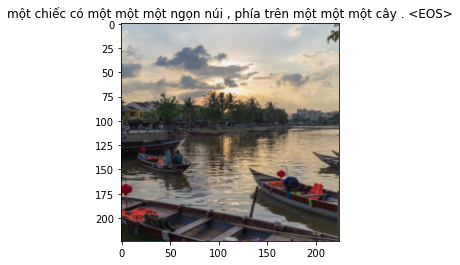

✅ Saved best model at epoch 1 with CIDEr: 0.1334
Epoch [2], Step [100], Loss: 3.9320
Epoch [2], Step [200], Loss: 3.7462
Epoch [2], Step [300], Loss: 3.5675
===> Epoch 2/20 | Loss: 3.8167 | BLEU: 0.0434 | CIDEr: 0.3246


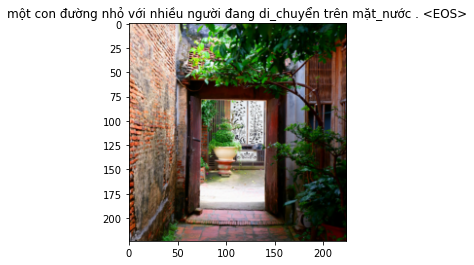

✅ Saved best model at epoch 2 with CIDEr: 0.3246
Epoch [3], Step [100], Loss: 3.2634
Epoch [3], Step [200], Loss: 3.0990
Epoch [3], Step [300], Loss: 3.1904
===> Epoch 3/20 | Loss: 3.2798 | BLEU: 0.0558 | CIDEr: 0.3710


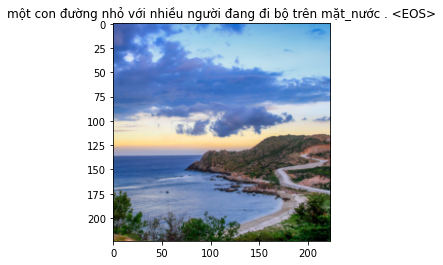

✅ Saved best model at epoch 3 with CIDEr: 0.3710
Epoch [4], Step [100], Loss: 2.8923
Epoch [4], Step [200], Loss: 2.9033
Epoch [4], Step [300], Loss: 2.9408
===> Epoch 4/20 | Loss: 2.9977 | BLEU: 0.0521 | CIDEr: 0.4225


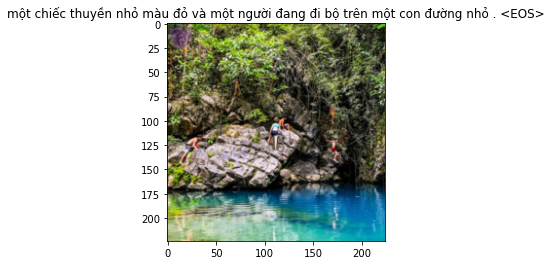

✅ Saved best model at epoch 4 with CIDEr: 0.4225
Epoch [5], Step [100], Loss: 3.0798
Epoch [5], Step [200], Loss: 2.9324
Epoch [5], Step [300], Loss: 2.7827
===> Epoch 5/20 | Loss: 2.8223 | BLEU: 0.0388 | CIDEr: 0.3715


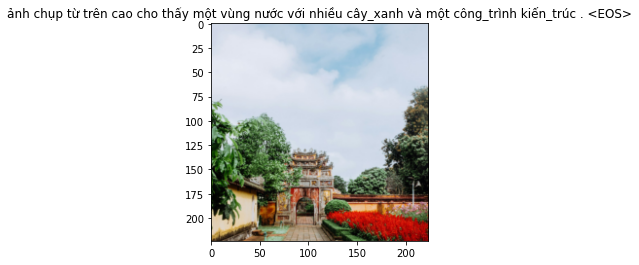

Epoch [6], Step [100], Loss: 2.6741
Epoch [6], Step [200], Loss: 2.4845
Epoch [6], Step [300], Loss: 2.6410
===> Epoch 6/20 | Loss: 2.6958 | BLEU: 0.0404 | CIDEr: 0.5799


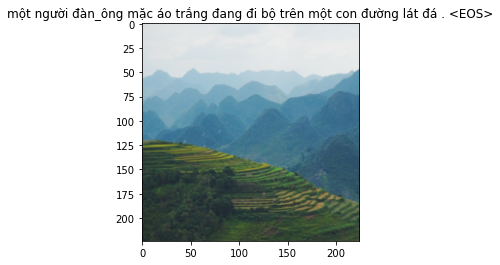

✅ Saved best model at epoch 6 with CIDEr: 0.5799
Epoch [7], Step [100], Loss: 2.6528
Epoch [7], Step [200], Loss: 2.8066
Epoch [7], Step [300], Loss: 2.5237
===> Epoch 7/20 | Loss: 2.5975 | BLEU: 0.0745 | CIDEr: 0.4924


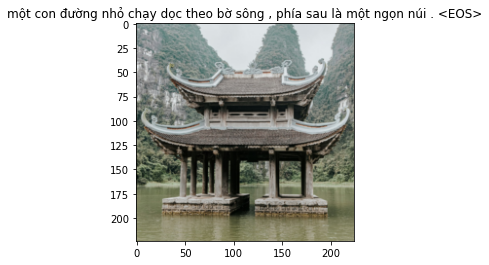

Epoch [8], Step [100], Loss: 2.5759
Epoch [8], Step [200], Loss: 2.6629
Epoch [8], Step [300], Loss: 2.5598
===> Epoch 8/20 | Loss: 2.5189 | BLEU: 0.0763 | CIDEr: 0.4609


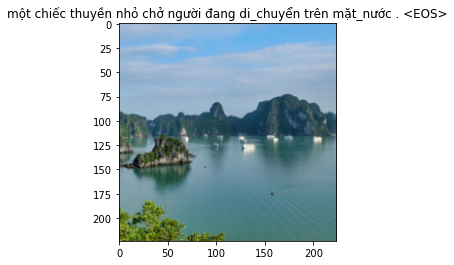

Epoch [9], Step [100], Loss: 2.4402
Epoch [9], Step [200], Loss: 2.5215
Epoch [9], Step [300], Loss: 2.4267
===> Epoch 9/20 | Loss: 2.4514 | BLEU: 0.0498 | CIDEr: 0.4491


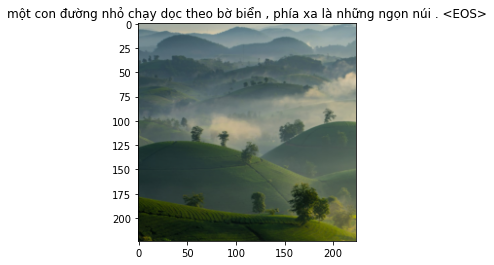

Epoch [10], Step [100], Loss: 2.3528
Epoch [10], Step [200], Loss: 2.4102
Epoch [10], Step [300], Loss: 2.4417
===> Epoch 10/20 | Loss: 2.3941 | BLEU: 0.0419 | CIDEr: 0.4221


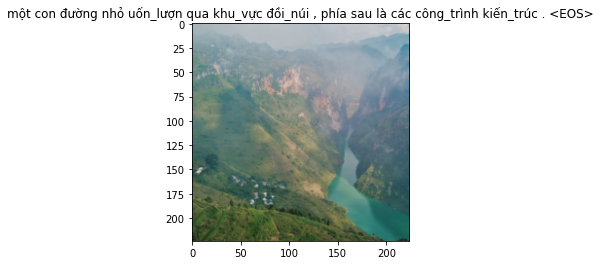

Epoch [11], Step [100], Loss: 2.4286
Epoch [11], Step [200], Loss: 2.3750
Epoch [11], Step [300], Loss: 2.4098
===> Epoch 11/20 | Loss: 2.3435 | BLEU: 0.0740 | CIDEr: 0.4871


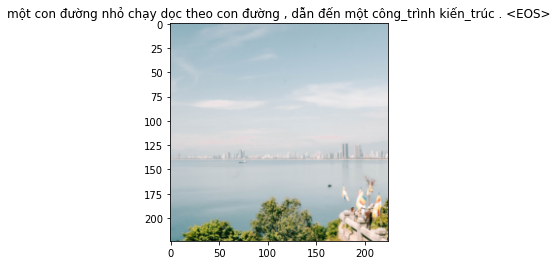

Epoch [12], Step [100], Loss: 2.4398
Epoch [12], Step [200], Loss: 2.3188
Epoch [12], Step [300], Loss: 2.2985
===> Epoch 12/20 | Loss: 2.2959 | BLEU: 0.0781 | CIDEr: 0.4994


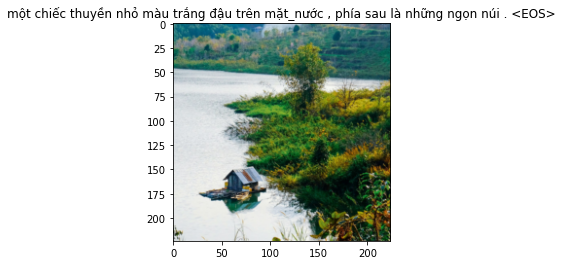

Epoch [13], Step [100], Loss: 2.1771
Epoch [13], Step [200], Loss: 2.2601
Epoch [13], Step [300], Loss: 2.1234
===> Epoch 13/20 | Loss: 2.2522 | BLEU: 0.0759 | CIDEr: 0.4803


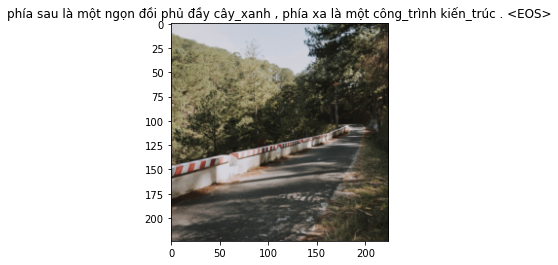

Epoch [14], Step [100], Loss: 2.1113
Epoch [14], Step [200], Loss: 2.1764
Epoch [14], Step [300], Loss: 2.1369
===> Epoch 14/20 | Loss: 2.2149 | BLEU: 0.0679 | CIDEr: 0.4788


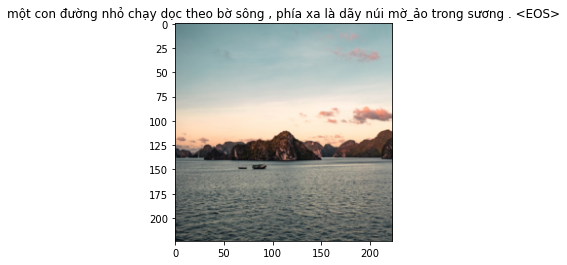

Epoch [15], Step [100], Loss: 2.1234
Epoch [15], Step [200], Loss: 2.2483
Epoch [15], Step [300], Loss: 2.1719
===> Epoch 15/20 | Loss: 2.1791 | BLEU: 0.0674 | CIDEr: 0.5442


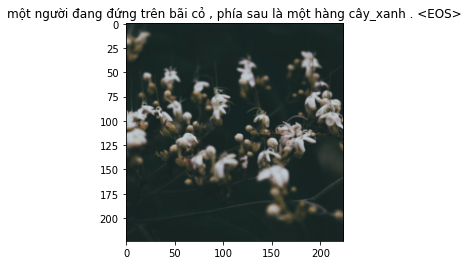

Epoch [16], Step [100], Loss: 2.0880
Epoch [16], Step [200], Loss: 2.2640
Epoch [16], Step [300], Loss: 2.0453
===> Epoch 16/20 | Loss: 2.1452 | BLEU: 0.0591 | CIDEr: 0.4064


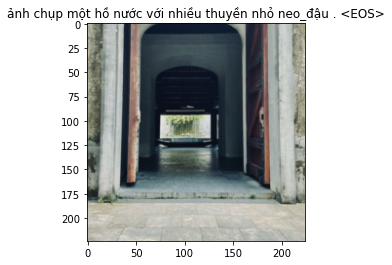

Epoch [17], Step [100], Loss: 2.0788
Epoch [17], Step [200], Loss: 2.0905
Epoch [17], Step [300], Loss: 2.0603
===> Epoch 17/20 | Loss: 2.1125 | BLEU: 0.0622 | CIDEr: 0.5893


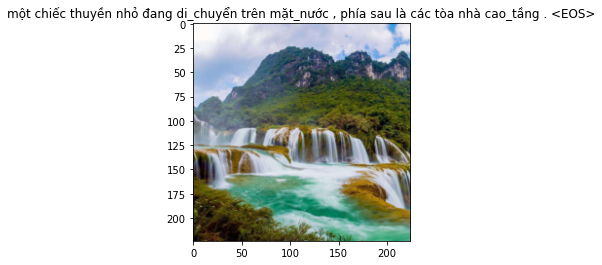

✅ Saved best model at epoch 17 with CIDEr: 0.5893
Epoch [18], Step [100], Loss: 2.1644
Epoch [18], Step [200], Loss: 2.1418
Epoch [18], Step [300], Loss: 2.0344
===> Epoch 18/20 | Loss: 2.0842 | BLEU: 0.0816 | CIDEr: 0.5125


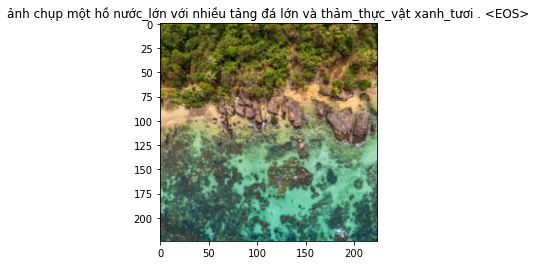

Epoch [19], Step [100], Loss: 1.9708
Epoch [19], Step [200], Loss: 1.8432
Epoch [19], Step [300], Loss: 2.1243
===> Epoch 19/20 | Loss: 2.0564 | BLEU: 0.0614 | CIDEr: 0.4531


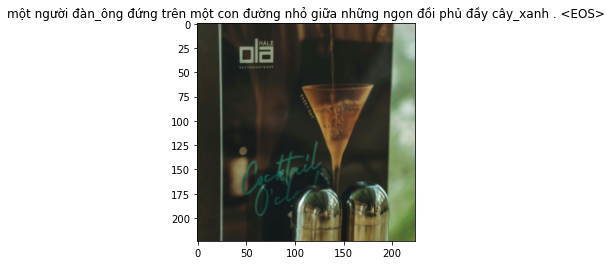

Epoch [20], Step [100], Loss: 2.0821
Epoch [20], Step [200], Loss: 2.0443
Epoch [20], Step [300], Loss: 2.1575
===> Epoch 20/20 | Loss: 2.0284 | BLEU: 0.0791 | CIDEr: 0.4947


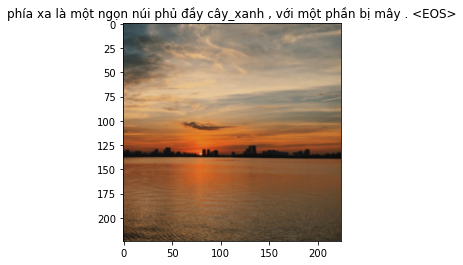

In [19]:
num_epochs = 20
print_every = 100

bleu_scores = []
train_losses = []
cider_scores = []

best_cider = -1.0
best_model_path = "best_model.pth"

for epoch in range(1, num_epochs + 1):  
    epoch_loss = 0
    model.train()

    for idx, (image, captions) in enumerate(data_loader):
        image, captions = image.to(device), captions.to(device)

        optimizer.zero_grad()
        outputs, attentions = model(image, captions)

        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (idx + 1) % print_every == 0:
            print(f"Epoch [{epoch}], Step [{idx+1}], Loss: {loss.item():.4f}")

    avg_loss = epoch_loss / len(data_loader)
    train_losses.append(avg_loss)

    # Đánh giá BLEU và CIDEr sau mỗi epoch
    model.eval()
    cider = evaluate_cider_pycoco(model, data_loader,dataset.vocab, device, max_samples=100)
    cider_scores.append(cider)

    bleu = evaluate_bleu_score(model, data_loader, dataset.vocab, device)
    bleu_scores.append(bleu)

    print(f"===> Epoch {epoch}/{num_epochs} | Loss: {avg_loss:.4f} | BLEU: {bleu:.4f} | CIDEr: {cider:.4f}")

    # Hiển thị caption mẫu
    with torch.no_grad():
        dataiter = iter(data_loader)
        img, _ = next(dataiter)
        features = model.encoder(img[0:1].to(device))
        caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(img[0], title=caption)

    # Lưu mô hình
    if cider > best_cider:
        best_cider = cider
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Saved best model at epoch {epoch} with CIDEr: {cider:.4f}")


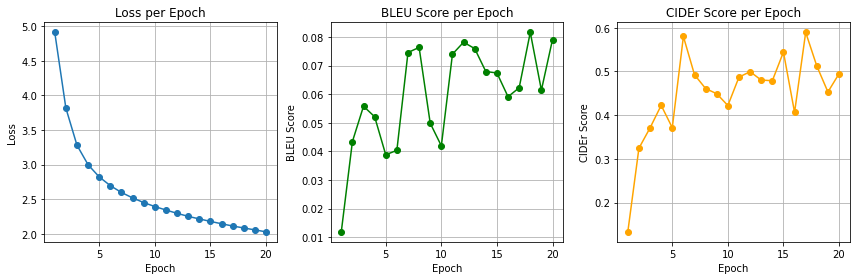

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

# BLEU
plt.subplot(1, 3, 2)
plt.plot(epochs, bleu_scores, marker='o', color='green')
plt.title("BLEU Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.grid()

# CIDEr
plt.subplot(1, 3, 3)
plt.plot(epochs, cider_scores, marker='o', color='orange')
plt.title("CIDEr Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("CIDEr Score")
plt.grid()

plt.tight_layout()
plt.show()


##  Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [21]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

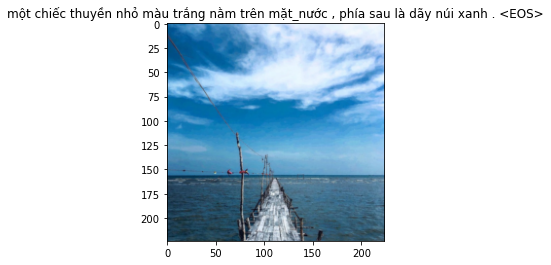

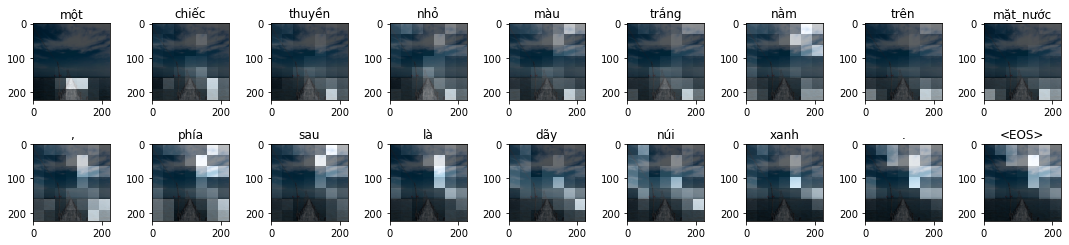

In [22]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

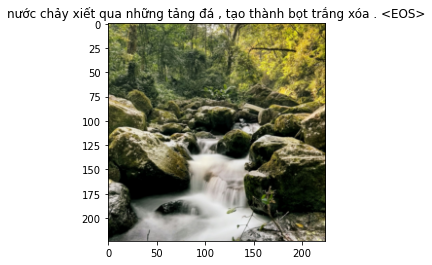

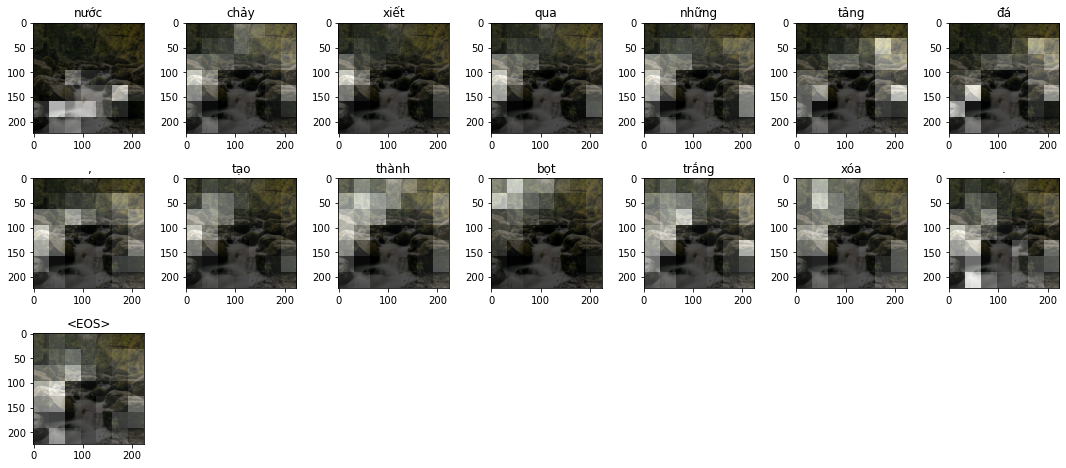

In [23]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

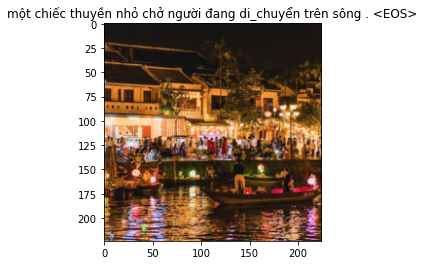

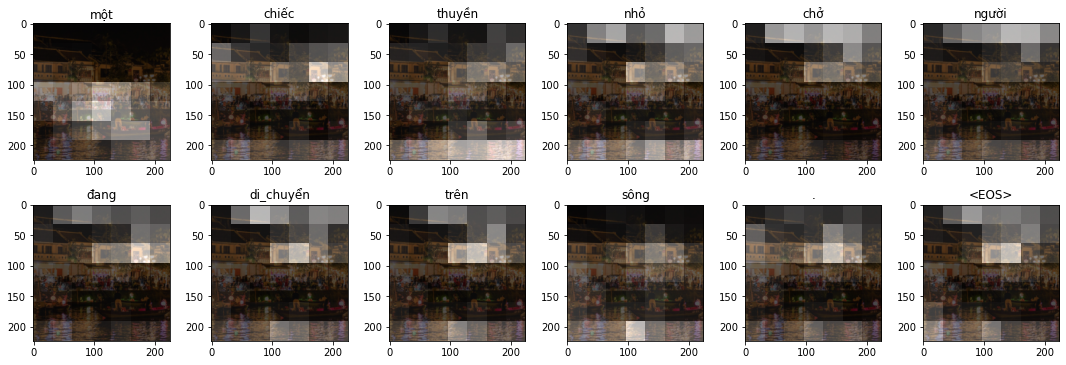

In [24]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

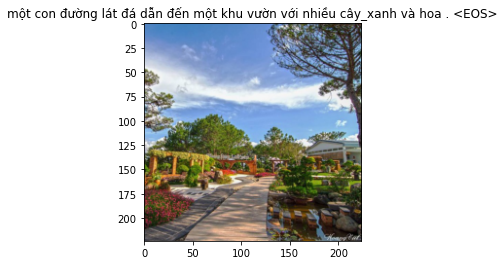

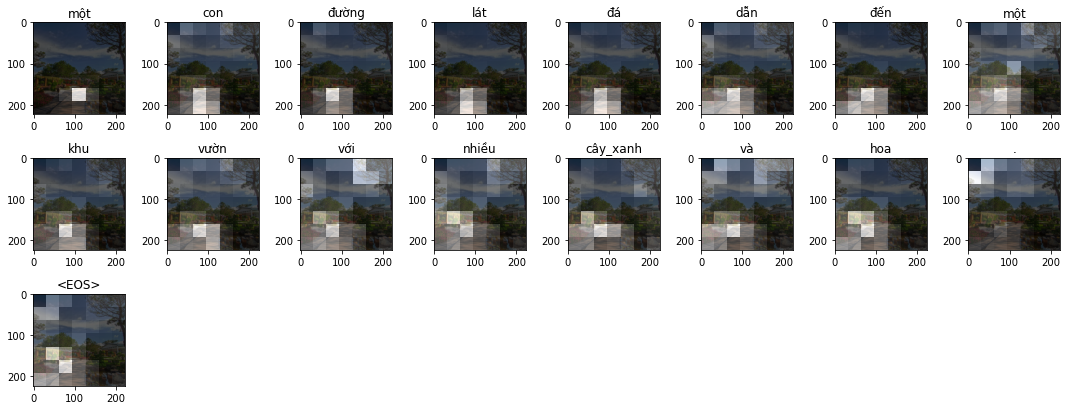

In [25]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)